In [13]:
#from biozorromodel import BioZorro
from datasets import load_from_disk
from encoders import BioZorroCollator

In [14]:
lm_datasets = load_from_disk('data/filtered_protein_mrna_genes')

In [15]:
lm_datasets = lm_datasets.rename_column('total_index','expression_index')
lm_datasets = lm_datasets.rename_column('total_data','expression_data')


In [16]:
#keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
keep = ['expression_index','expression_data','spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
remove = list()
for key in lm_datasets.features.keys():
    if key not in keep:
        remove.append(key)
lm_datasets = lm_datasets.remove_columns(remove)

In [17]:
from torch.utils.data import DataLoader
default_data_collator = BioZorroCollator(pad_len=2048, pad_token=0)
dataloader = DataLoader(lm_datasets.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)

In [18]:
dl = iter(dataloader)
batch = next(dl)

In [57]:
#https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size
import numpy as np
vocab_size = 18817
num_embeddings = int(75.6496 * np.log(vocab_size + 176.623) - 41.4457)
print(num_embeddings)

703


In [74]:
2.5*10**5*256/8

8000000.0

In [62]:
config = {
    "dim": num_embeddings, #hidden size
    "depth": 3, #layers
    "spliced_input_dim": num_embeddings, #embedding_size
    "unspliced_input_dim": num_embeddings,
    "dim_head":64, #don't know, head hidden size?
    "heads": 4, #num heads
    "ff_mult": 4, #Feed forward multiplier
    "num_fusion_tokens": 16,
    "vocab_size": vocab_size
}

model = BioZorro(**config)

In [63]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(f"{n}:{p.numel()/10**6}")

return_tokens:0.002109
fusion_tokens:0.011248
loss.contrastive_loss.logit_scale:1e-06
attn_pool.norm.gamma:0.000703
attn_pool.to_q.weight:0.179968
attn_pool.to_kv.weight:0.359936
attn_pool.to_out.weight:0.179968
spliced_embedding.gene_encoder.embedding.weight:13.228351
spliced_embedding.gene_encoder.enc_norm.weight:0.000703
spliced_embedding.gene_encoder.enc_norm.bias:0.000703
spliced_embedding.counts_encoder.linear1.weight:0.000703
spliced_embedding.counts_encoder.linear1.bias:0.000703
spliced_embedding.counts_encoder.linear2.weight:0.494209
spliced_embedding.counts_encoder.linear2.bias:0.000703
spliced_embedding.counts_encoder.norm.weight:0.000703
spliced_embedding.counts_encoder.norm.bias:0.000703
unspliced_embedding.gene_encoder.embedding.weight:13.228351
unspliced_embedding.gene_encoder.enc_norm.weight:0.000703
unspliced_embedding.gene_encoder.enc_norm.bias:0.000703
unspliced_embedding.counts_encoder.linear1.weight:0.000703
unspliced_embedding.counts_encoder.linear1.bias:0.000703


In [61]:
outputs = model(**batch)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 703 but got size 128 for tensor number 1 in the list.

In [41]:
outputs

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss=tensor(10.3229, grad_fn=<DivBackward0>), fusion_loss_spliced=tensor(2.3723, grad_fn=<DivBackward0>), fusion_loss_unspliced=tensor(3.2532, grad_fn=<DivBackward0>)), spliced_output=None, unspliced_output=None, fusion_output=None)

In [ ]:
outputs.loss.backward()

In [ ]:
import wandb
wandb.init()

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

epochs=100
optimizer = AdamW(model.parameters(), lr=0.0001)
num_training_steps = epochs * len(dataloader)
progress_bar = tqdm(range(num_training_steps))

#print("Start training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))
## Start model training and defining the training loop
model.train()
for epoch in range(epochs):
    for batch in dataloader:
        #batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        optimizer.zero_grad()
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
        wandb.log({"loss":loss.detach().to("cpu")})
    print(f"Epoch {epoch}: loss: {loss.detach()}")
        #
    #if xm.is_master_ordinal(local=False):
    wandb.log({"epoch_loss":loss.detach().to("cpu")})

logger.info("End training: {}".format(strftime("%Y-%m-%d %H:%M:%S", gmtime())))

In [17]:
from collections import defaultdict
import torch
losses = defaultdict(lambda: torch.Tensor([0.0]).to("cpu"))
losses['test']+=torch.Tensor([1.0])

# Scaling law results

In [5]:
import pandas as pd
import numpy as np
nparam = np.array([76.65,38.81,32.5, 26.23,
                   19.94,13.64,10.50,7.35])*10**6
nlayers = np.array([24,16,10,8,6,4,3,2])
sm_loss = { 'fusion_spliced': [0.05217,0.055660,0.05406000, 0.04967,
                               0.0688, 0.0625,0.06375,0.07791],
           'fusion_unspliced':[0.05201,0.055482,0.05395645, 0.04972,
                               0.06859,0.0624,0.06347,0.07738],
           'contrastive_loss':[0.051933,0.05556,0.054283, 0.0499,
                               0.06961,0.0638,0.06341,0.07857]
}
dm_loss = { 'fusion_spliced':[0.002226,0.004596, 0.0047380,0.003942,
                              0.005551,0.005522,0.005401,0.01271],
           'fusion_unspliced':[0.002172,0.0046209,0.0047747,0.004004,
                               0.005403,0.005479,0.005485,0.01249],
           'contrastive_loss':[0.002259,0.004727,0.0048772,0.00414,
                               0.005551,0.005278,0.005551,0.01522]
}

dm_loss=np.array(list(dm_loss.values()))
dm_loss = dm_loss.sum(axis=0)
#dm_loss=dm_loss[:,:-1].sum(axis=0)
sm_loss=np.array(list(sm_loss.values()))
sm_loss = sm_loss.sum(axis=0)
#sm_loss=sm_loss[:,:-1].sum(axis=0)
#nparam=nparam[:-1]
df = pd.DataFrame.from_dict({'dual':dm_loss,
                             'single':sm_loss,
                             'param':nparam})
df_m = pd.DataFrame.from_dict({'dual':dm_loss/dm_loss.mean(),
                               'single':sm_loss/sm_loss.mean(),
                               'param':nparam})
df.to_csv('prelim_scale_data.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33337f34d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f33317b8550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317b8c10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  
/shared/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f33317379d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
/shared/miniconda3/lib/pyth

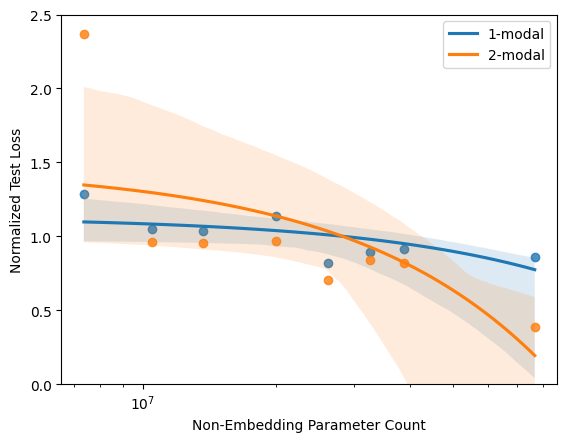

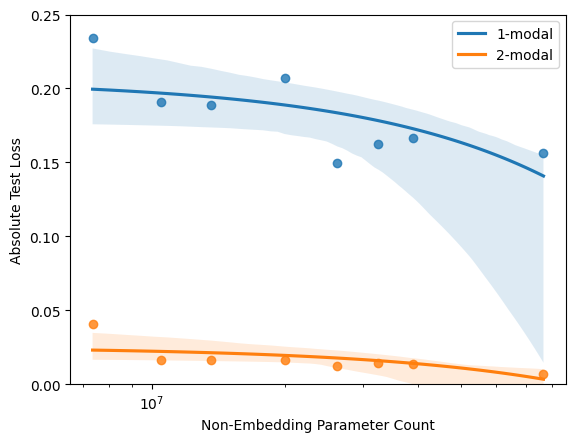

In [4]:
sm_loss_ = sm_loss
dm_loss_ = dm_loss
nparam_ = nparam
nlayers_ = nlayers
plt.clf()
plt.figure(1)
#plt.plot(nparam_,np.array(sm_loss_)/sm_loss_.mean(),'o-',
#         nparam_,np.array(dm_loss_)/dm_loss_.mean(),'x-')
sns.regplot(df_m, x='param',y='single')
sns.regplot(df_m, x='param',y='dual')
plt.xscale('log')
#plt.xlim([9*10**6,10**8])
plt.ylim([0,2.5])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Normalized Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
plt.figure(2)
#plt.plot(nparam_,np.array(sm_loss_),'o-',
#         nparam_,np.array(dm_loss_),'x-')
sns.regplot(df, x='param',y='single')
sns.regplot(df, x='param',y='dual')
plt.xscale('log')
plt.ylim([0,0.25])

#plt.xlim([5*10**6,10**8])
plt.xlabel('Non-Embedding Parameter Count')
plt.ylabel('Absolute Test Loss')
plt.legend(['_nolegend_',"1-modal",'_nolegend_','_nolegend_',"2-modal"]) 
#, "1-modal", "2-modal"])

# Testing Pretrained Model

In [1]:
from safetensors.torch import load_model
import json
import os
import torch

In [2]:
import datasets
!ls /shared/

ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all
cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all_veloc_sparse
fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all
genecorpus_30M_10p_2048.dataset
genecorpus_30M_1p_2048.dataset
genecorpus_30M_2048.dataset
lost+found
miniconda3
neuron_cache
tmp


In [1]:
from multizorromodel import BioZorro
import datasets
from torch.utils.data import DataLoader
from encoders import BioZorroCollatorWithTargets
!ls training_output_21_31_23_10_2023
output_dir = 'training_output_21_31_23_10_2023'

config.yaml	   random_states_0.pkl	random_states_5.pkl
model.safetensors  random_states_1.pkl	random_states_6.pkl
model_config.json  random_states_2.pkl	random_states_7.pkl
optimizer.bin	   random_states_3.pkl	scheduler.bin
pytorch_model.bin  random_states_4.pkl


In [4]:
import yaml
with open(os.path.join(output_dir,'config.yaml'), 'r') as file:
    config = yaml.safe_load(file)
print(config)

{'batch_size': 4, 'dataset': '/shared/fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all', 'dim_head': 8, 'ds_frac': 1, 'ds_seed': 42, 'epochs': 1, 'ff_mult': 4, 'heads': 8, 'hidden_size': 512, 'layers': 5, 'lr': 0.0001, 'lr_scheduler_type': 'cosine', 'model': 3, 'n_params_emb': 57013248, 'n_params_nonemb': 11286017, 'num_fusion_tokens': 16, 'num_warmup_steps': 3000, 'output_dir': 'training_output_21_31_23_10_2023'}


In [5]:
with open(os.path.join(output_dir,'model_config.json'),'r') as f:
    model_config = json.load(f)
print(model_config)

{'dim': 512, 'depth': 5, 'dim_head': 8, 'heads': 8, 'ff_mult': 4, 'num_fusion_tokens': 16}


In [2]:
#dataset = datasets.load_from_disk(config['dataset'])
#dataset2 = datasets.load_from_disk('/shared/fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all')
dataset3 = datasets.load_from_disk('/shared/fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all_veloc_sparse')

In [ ]:
# Get some indices in the top rankings
indices = [x[0:5] for x in dataset3[0:10000]['velocity_index']]
indices = [x for y in indices for x in y]

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(indices, bins=100)

In [27]:
len(set(indices))

1763

In [3]:
#keep =  ['spliced_index', 'unspliced_index', 'spliced_data', 'unspliced_data']
#keep = ['expression_index','expression_counts','spliced_index', 'unspliced_index', 'spliced_counts', 'unspliced_counts']
keep = ['velocity_index','velocity_data','expression_index',
        'expression_data','spliced_index', 'unspliced_index',
        'spliced_data', 'unspliced_data']

remove = list()
for key in dataset3.features.keys():
    if key not in keep:
        remove.append(key)
#dataset = dataset.remove_columns(remove)
#dataset2 = dataset2.remove_columns(remove)
dataset3 = dataset3.remove_columns(remove)
dataset3

Dataset({
    features: ['spliced_index', 'spliced_data', 'unspliced_index', 'unspliced_data', 'velocity_index', 'velocity_data', 'expression_index', 'expression_data'],
    num_rows: 400315
})

In [28]:
dataset3[0]['velocity_index']

[33027,
 5717,
 27559,
 14163,
 35589,
 15531,
 9650,
 29464,
 7085,
 19768,
 26069,
 34288,
 5295,
 24011,
 7377,
 10282,
 14992,
 32715,
 12299,
 985,
 5718,
 4178,
 29732,
 12093,
 22185,
 629,
 3000,
 25590,
 318,
 7376,
 9894,
 25850,
 24052,
 13920,
 31991,
 11548,
 859,
 24073,
 17572,
 20018,
 19037,
 32491,
 640,
 30026,
 7757,
 5642,
 33881,
 1043,
 7375,
 31478,
 4859,
 5519,
 13016,
 19309,
 18537,
 12595,
 30963,
 36377,
 25405,
 35409,
 23142,
 250,
 25536,
 32813,
 9574,
 121,
 34071,
 1431,
 23140,
 15739,
 29615,
 33593,
 2177,
 15798,
 19060,
 13929,
 30945,
 971,
 29237,
 25911,
 34027,
 9507,
 16727,
 24660,
 29622,
 5343,
 5244,
 34533,
 1050,
 13129,
 7928,
 3877,
 22962,
 369,
 29616,
 28880,
 18008,
 18541,
 6120,
 12451,
 35716,
 27207,
 21697,
 33044,
 5975,
 35241,
 24478,
 4906,
 31736,
 17468,
 339,
 9539,
 15154,
 23375,
 10468,
 3034,
 23148,
 29325,
 29233,
 32034,
 35454,
 34445,
 34311,
 34643,
 11409,
 23810,
 10451,
 16977,
 1665,
 34396,
 3519,
 555

In [15]:
#default_data_collator = BioZorroCollator(pad_len=2048, pad_token=0)
default_data_collator = BioZorroCollatorWithTargets(pad_len=1024, pad_token=0)

#dataloader = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader3 = DataLoader(dataset3.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)

In [16]:
#dl=iter(dataloader)
#dl=iter(dataloader3)
dl = iter(dataloader3)
batch = next(dl)
#batch2= next(dl2):q

for k,v in batch.items():
    print(f"{k} {v.shape}")

spliced_index torch.Size([4, 1024])
spliced_data torch.Size([4, 1024])
unspliced_index torch.Size([4, 1024])
unspliced_data torch.Size([4, 1024])
expression_index torch.Size([4, 1024])
expression_data torch.Size([4, 1024])
velocity torch.Size([4, 36601])


In [17]:
batch['velocity'][3].nonzero().shape

torch.Size([5159, 1])

In [7]:
import torch
x = torch.zeros(100)
x[torch.tensor([0,2,4,6])]=torch.tensor([0,1,0.2,0.5])
x

tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.2000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [113]:
model = BioZorro(**model_config)
model.eval()
with torch.no_grad():
    output1 = model(**batch)

In [114]:
load_model(model,os.path.join(output_dir,'model.safetensors'))

(set(), [])

In [84]:
def zero_modes(batch, modes=keep):
    for mode in modes:
        batch[mode][0]=batch[mode][0]*0
    return batch

In [170]:
output=[]
output2=[]
with torch.no_grad():
    for i in range(20):
        batch = next(dl)
        batch2 = next(dl2)
        output.append(model(**batch))
        output2.append(model(**batch2))
        #output2 = model(**zero_modes(batch))

In [171]:
def refactor(outputs):
    assert isinstance(outputs,list)
    out_dict = {k:[] for k in outputs[0] if 'loss' not in k}
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict
output = refactor(output)
output2 = refactor(output2)

In [178]:
print(output['spliced'][0][:10])
print(output2['spliced'][0][:10])

tensor([-1.1217, -1.1749, -0.2800, -0.5200,  0.7978,  0.6638, -0.3283, -2.1173,
         0.3225, -1.3359])
tensor([-1.1115, -1.1441, -0.2409, -0.4363,  0.8337,  0.6894, -0.3162, -2.1065,
         0.3249, -1.2489])


In [185]:
import numpy as np

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None):
    if not output2:
        output2 = output
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k]
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    for k,mat in mat_dict.items():
        plt.figure()
        plt.title(k)
        plt.imshow(mat, vmin=vmin, vmax=vmax)
        plt.colorbar()
        

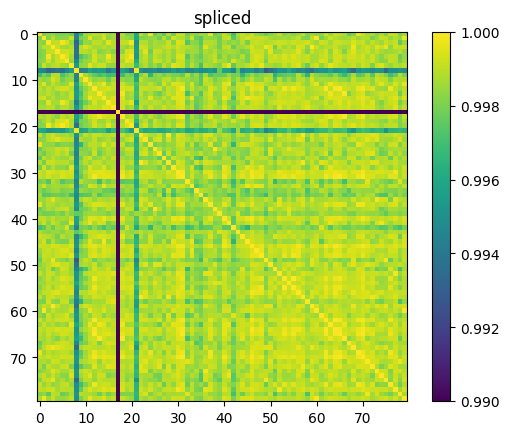

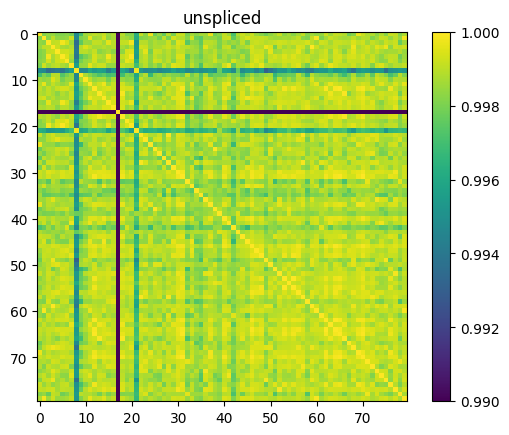

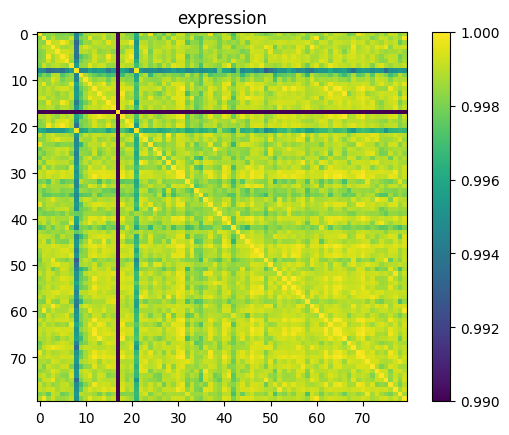

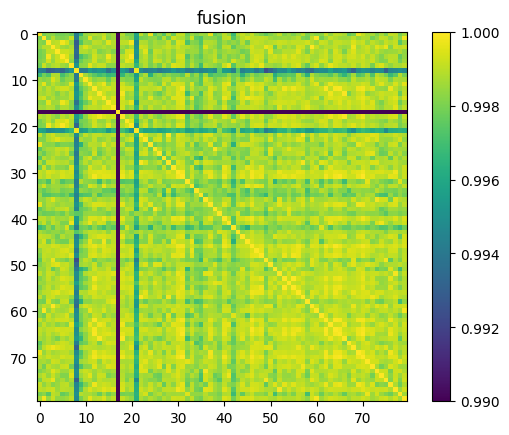

In [188]:
plot_cosines(output,vmin=0.99)

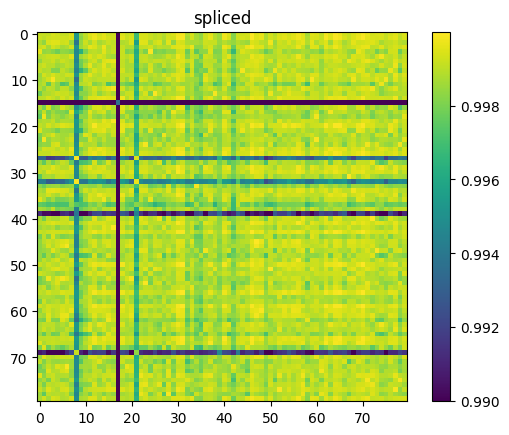

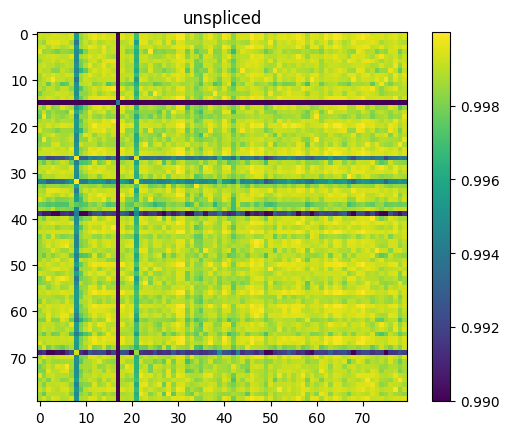

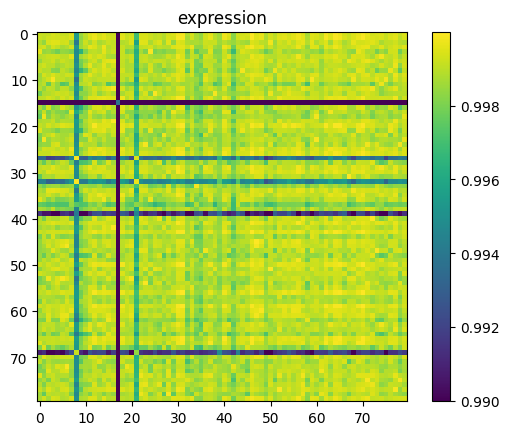

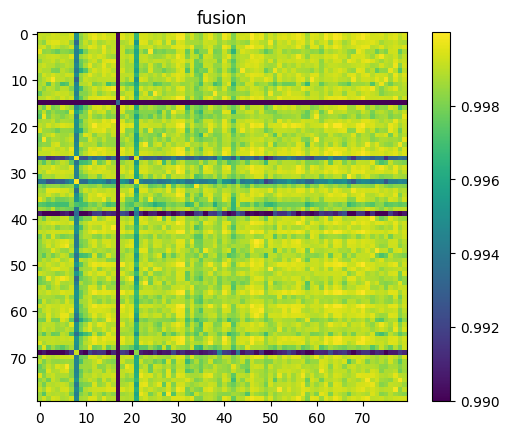

In [190]:
plot_cosines(output2, output, vmin=0.99)

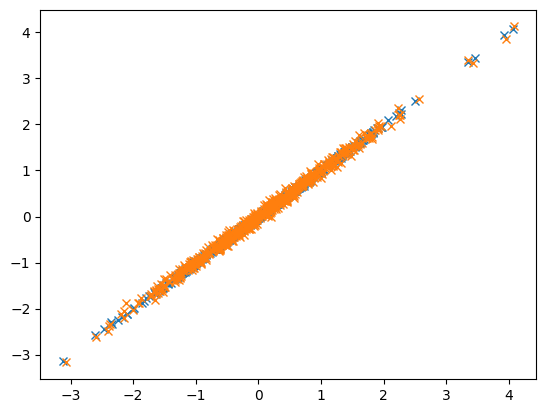

In [118]:
import matplotlib.pyplot as plt
plt.plot(output.spliced[0].T, output2.spliced[0].T,'x')
plt.plot(output.spliced[1].T, output2.spliced[3].T,'x')

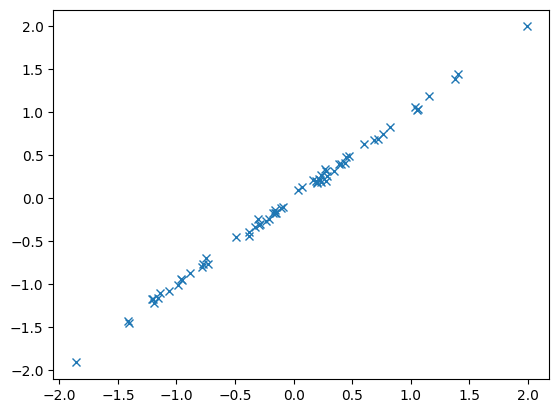

In [35]:
plt.plot(output.expression[0].T, output2.expression[0].T,'x')

In [97]:
output

BioZorroPretrainingLossOutput(losses=BioZorroPretrainingLossesCollection(contrastive_loss_spliced_unspliced=tensor(0.4164), contrastive_loss_spliced_expression=tensor(0.4097), contrastive_loss_unspliced_expression=tensor(0.4155), fusion_loss_spliced=tensor(0.4160), fusion_loss_unspliced=tensor(0.4218), fusion_loss_expression=tensor(0.4208)), spliced=tensor([[-1.1495, -1.1352, -0.2678,  ..., -1.6399,  1.2685, -1.6200],
        [-1.1184, -1.1473, -0.2358,  ..., -1.6374,  1.3286, -1.6621],
        [-1.1103, -1.1614, -0.2176,  ..., -1.6670,  1.3458, -1.6997],
        [-1.1442, -1.1956, -0.2705,  ..., -1.7048,  1.3194, -1.6719]]), unspliced=tensor([[-0.5714, -0.6153, -0.6491,  ...,  0.5839,  1.0429, -1.6685],
        [-0.5403, -0.6274, -0.6171,  ...,  0.5865,  1.1030, -1.7106],
        [-0.5323, -0.6415, -0.5989,  ...,  0.5568,  1.1202, -1.7482],
        [-0.5661, -0.6758, -0.6517,  ...,  0.5191,  1.0937, -1.7204]]), expression=tensor([[-1.1063, -0.1184, -0.6933,  ...,  0.0146,  0.0636,  0.

# Attention masking tests

In [61]:
import torch
token_types = torch.tensor(list((
    *((0,) * 2048),
    *((1,) * 2048),
    *((2,) * 2048),
    *((3,) * 2048),
)), dtype=torch.long)

In [62]:
token_types.shape

torch.Size([8192])

In [63]:
from einops import rearrange

In [64]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [65]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [66]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

In [67]:
zorro_mask.shape

torch.Size([8192, 8192])

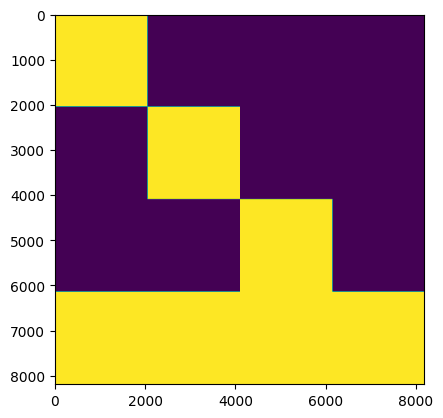

In [68]:
import matplotlib.pyplot as plt
plt.imshow(zorro_mask)

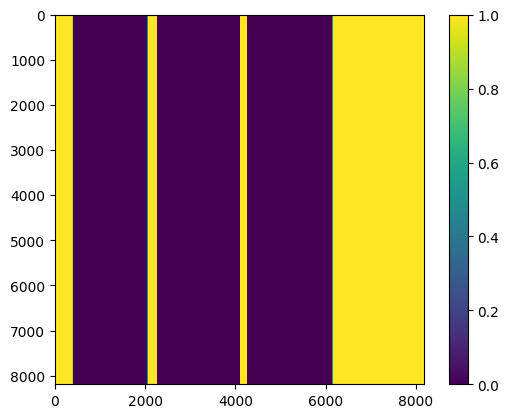

In [169]:
from einops import pack,repeat
padding, ps = pack((
    batch['expression_index'] != 0,
    batch['spliced_index'] != 0,
    batch['unspliced_index'] != 0,
    torch.ones(4,2048),
   #Also need fusion tokens here torch.tensor((True,) * 16),
    ), 'b *')
attn_mask = repeat(padding, 'b j -> b i j', i=tokens.shape[-1])
plt.imshow(attn_mask[0].squeeze())
plt.colorbar()

In [165]:
attn_mask.unsqueeze(1).shape

torch.Size([4, 1, 8192, 8192])

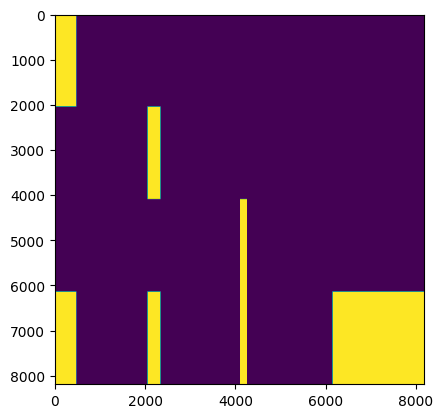

In [166]:
plt.imshow(attn_mask[2,:,:] * zorro_mask)

In [72]:
torch.empty(0)

tensor([])

In [73]:
batch

{'expression_index': tensor([[  7,  10,  60,  ...,   0,   0,   0],
         [ 18,  49,  53,  ...,   0,   0,   0],
         [  3,  17,  26,  ...,   0,   0,   0],
         [ 60,  67, 136,  ...,   0,   0,   0]]),
 'spliced_index': tensor([[ 10,  60, 204,  ...,   0,   0,   0],
         [ 49, 134, 351,  ...,   0,   0,   0],
         [ 17,  46,  60,  ...,   0,   0,   0],
         [ 60, 183, 191,  ...,   0,   0,   0]]),
 'unspliced_index': tensor([[  7, 103, 238,  ...,   0,   0,   0],
         [ 18,  53, 120,  ...,   0,   0,   0],
         [ 26, 153, 198,  ...,   0,   0,   0],
         [136, 160, 332,  ...,   0,   0,   0]]),
 'expression_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'spliced_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 2., 1.,  ..., 0., 0., 0.]]),
 'unspl

In [132]:
return_token_types = (0,1,2,3,4,4,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [133]:
return_tokens.shape

torch.Size([4, 7, 512])

In [134]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

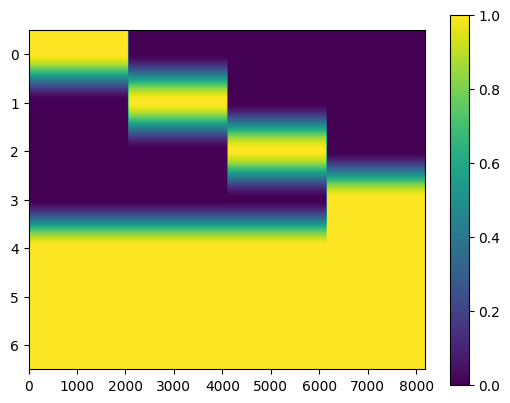

In [135]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

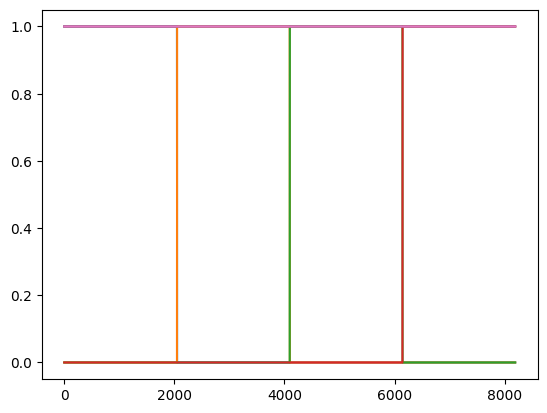

In [136]:
plt.plot(pool_mask.T)

torch.Size([4, 7, 8192])


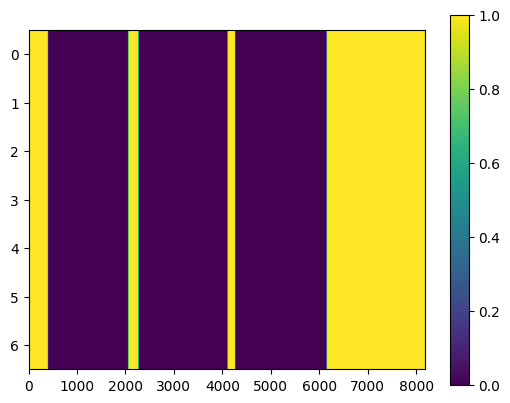

In [137]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

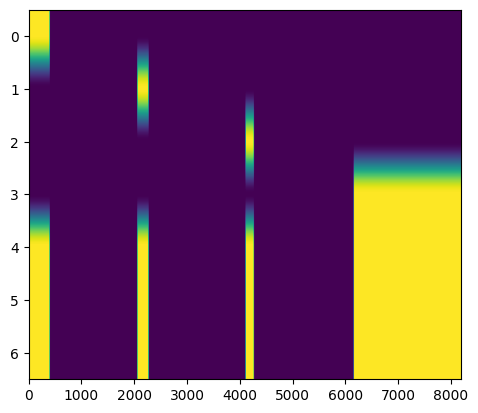

In [174]:
pool_mask = pool_mask * padding_mask
plt.imshow(pool_mask[0], aspect=1000)

In [160]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [163]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

tensor([[3, 4],
        [2, 3]])
tensor([[ 7, 10],
        [ 5,  7]])


In [156]:
sim

tensor([[2, 0],
        [0, 2]])